### Methods

We will conduct our data analysis using classification. The variables/columns we will use are:
1. Sector_score: Historical risk score value of the target unit using analytical procedure
2. PARA_A: Discrepancy found in the planned expenditure of inspection and summary report
3. PARA_B: Discrepancy found in the unplanned expenditure of inspection and summary report B
4. TOTAL: Total discrepancy found in the planned expenditure of inspection and summary report
5. Money_Value: Amount of money involved in misstatements in the past audits
6. Score: Total risk score using an analytical procedure

Firstly, we will create the train / test split, and then split the training data to train / validation. A recipe that specifies the predictors will be created, followed by the nearest_neighbors model specification. After choosing the most optimal K value from cross validation, we will retrain the classifier. Finally, we will evaluate the estimated accuracy of the classifier on the test set. One of the visualization methods we are going to use are scatter plots between every 2 of the predictors to see the correlation between them and how the target class is distributed.

### Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

In [2]:
# reading data from the file
url = "https://raw.githubusercontent.com/VYang4/trial.csv/main/trial.csv"
trial <- read_csv(url)
trial |> head(5)

Rows: 776 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (17): Sector_score, PARA_A, SCORE_A, PARA_B, SCORE_B, TOTAL, numbers, Ma...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,23,4.18,6,2.50,2,6.68,5,2,3.38,2,2,0,2,0,2,2.4,1
3.89,6,0.00,2,4.83,2,4.83,5,2,0.94,2,2,0,2,0,2,2.0,0
3.89,6,0.51,2,0.23,2,0.74,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,6,0.00,2,10.80,6,10.80,6,6,11.75,6,2,0,2,0,2,4.4,1
3.89,6,0.00,2,0.08,2,0.08,5,2,0.00,2,2,0,2,0,2,2.0,0


#### Table 1. Sample of dataset with the chosen predictors

In [3]:
# mutating the target column Risk to be a factor
trial <- trial |> mutate(Risk = as_factor(Risk))
# Selecting the nessesary columns 
trial <- select(trial, PARA_A, PARA_B, Money_Value, Risk)
trial <- trial |> drop_na()
trial |> head(5)

PARA_A,PARA_B,Money_Value,Risk
<dbl>,<dbl>,<dbl>,<fct>
4.18,2.50,3.38,1
0.00,4.83,0.94,0
0.51,0.23,0.00,0
0.00,10.80,11.75,1
0.00,0.08,0.00,0


In [4]:
set.seed(1000)
# Spliting the dataset into 75% training and 25% testing data
trial_split <- initial_split(trial, prop = 0.75, strata = Risk)
trial_train <- training(trial_split)
trial_test <- testing(trial_split) 

#### Table 2. Proportions of the risky/not risky compinies in the dataset. (1 - risky, 0 - not risky)

In [5]:
trial_proportions <- trial_train |>
                      group_by(Risk) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(trial_train))
trial_proportions

Risk,n,percent
<fct>,<int>,<dbl>
0,216,37.24138
1,364,62.75862


#### Table 3. The mean values of the chosen parameters with regard to the target class

In [6]:
mean_statistics <- trial_train |>
              group_by(Risk) |>
              summarize(mean_para_a = mean(PARA_A), mean_para_b = mean(PARA_B), mean_money_value = mean(Money_Value))

mean_statistics

Risk,mean_para_a,mean_para_b,mean_money_value
<fct>,<dbl>,<dbl>,<dbl>
0,0.3006944,0.2513157,0.28400
1,3.8406885,18.8677473,24.27308


#### Figure 1. Parameter A vs. Parameter B 

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


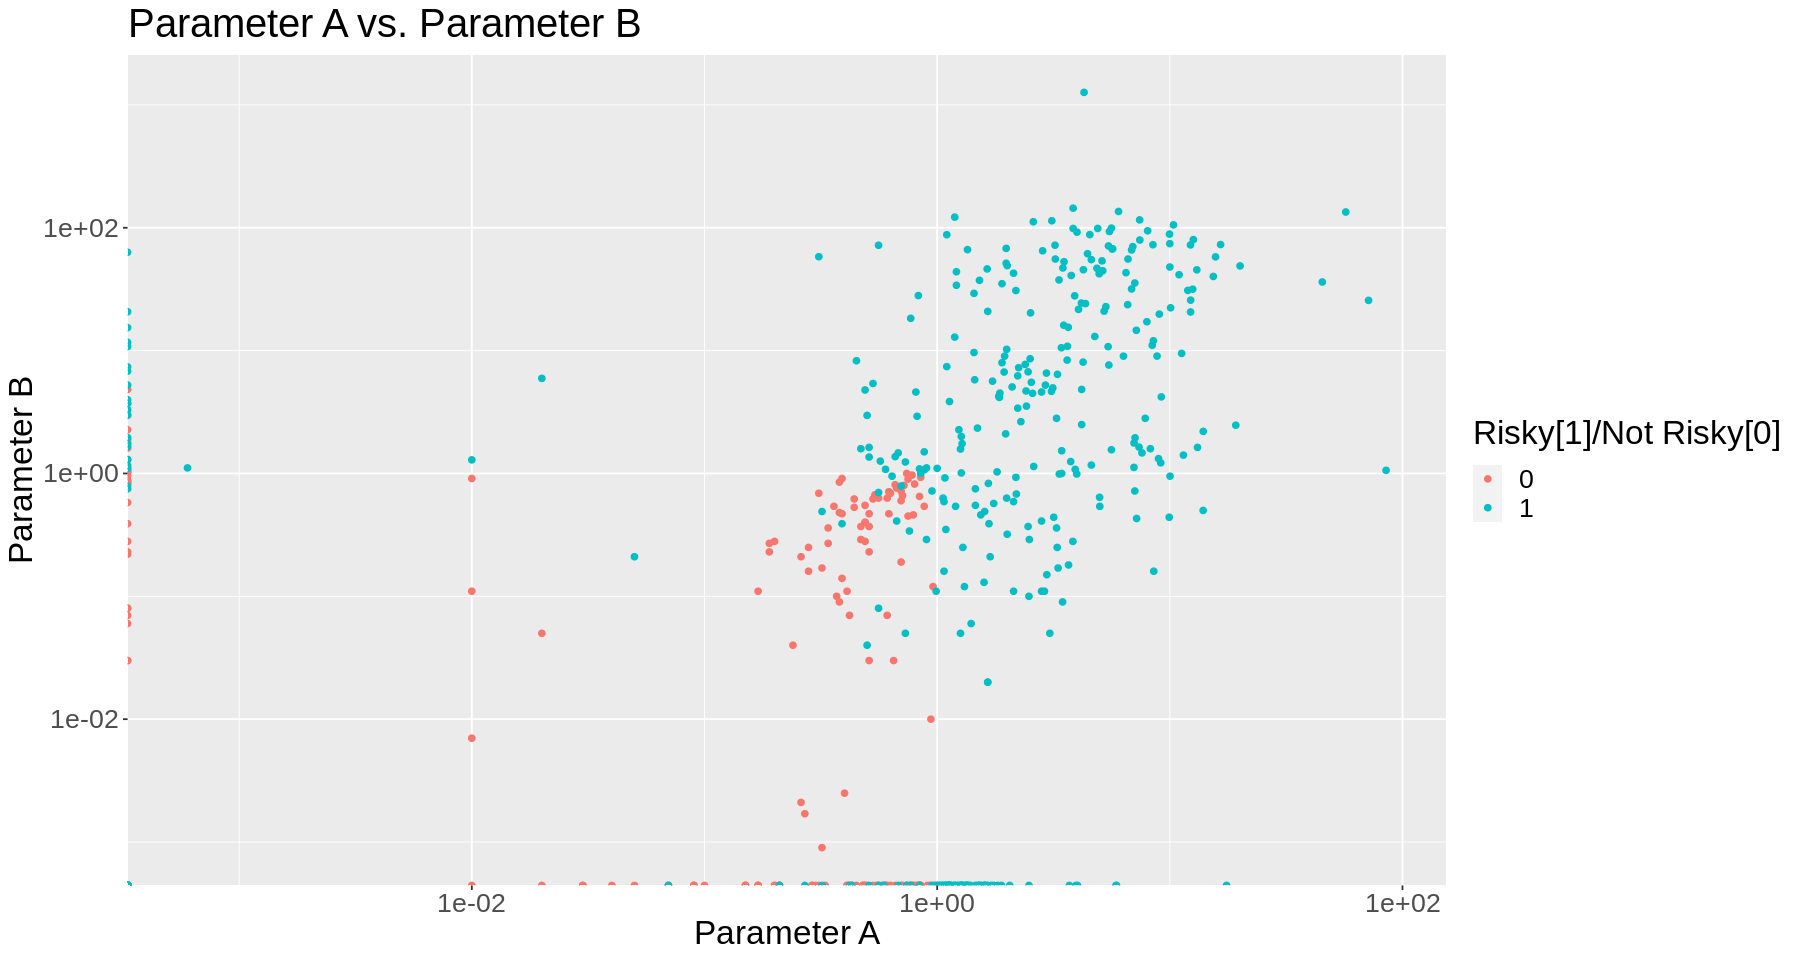

In [7]:
options(repr.plot.width=15, repr.plot.height=8)
para_a_para_b_chart <- trial_train |>
                           ggplot(aes(x=PARA_A, y=PARA_B, color=Risk)) + 
                           geom_point() + ggtitle("Parameter A vs. Parameter B") + 
                           labs(x="Parameter A", y="Parameter B", color="Risky[1]/Not Risky[0]") + scale_x_log10() + scale_y_log10() + theme(text = element_text(size = 20))

para_a_para_b_chart

#### Figure 2. Parameter A vs. Money Value

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


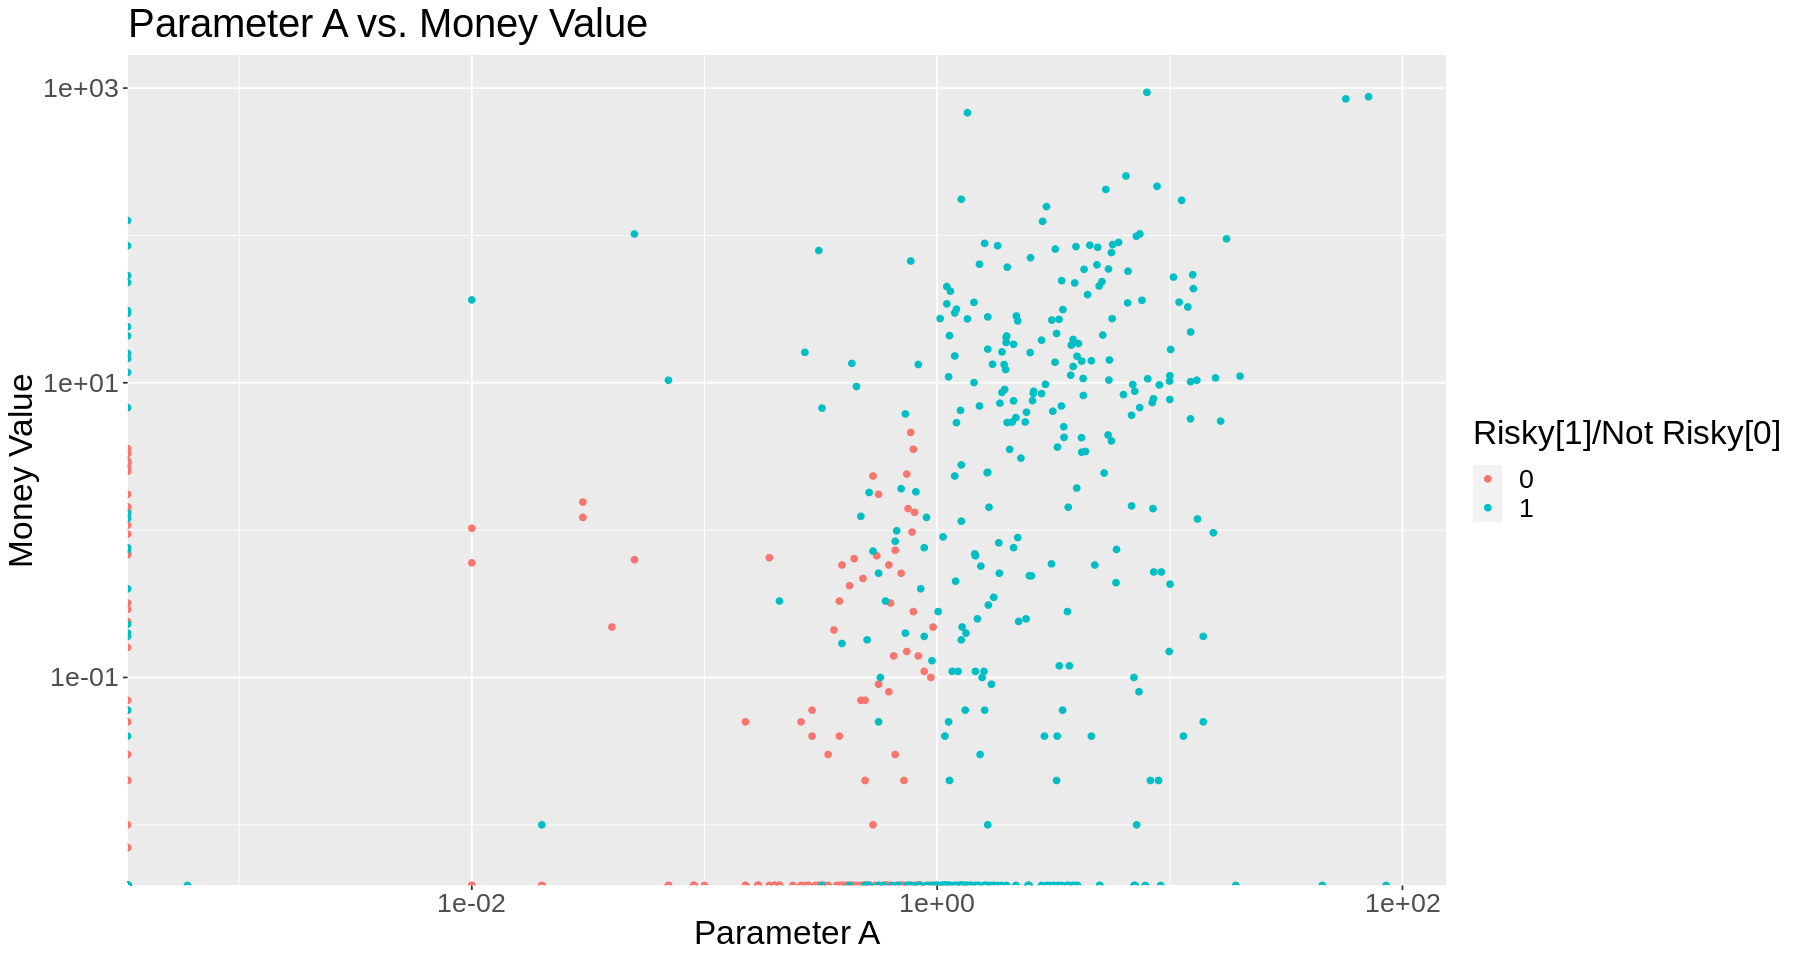

In [8]:
options(repr.plot.width=15, repr.plot.height=8)
sector_score_total_chart <- trial_train |>
                           ggplot(aes(x=PARA_A, y=Money_Value, color=Risk)) +
                           geom_point() + ggtitle("Parameter A vs. Money Value") +
                           labs(x="Parameter A", y="Money Value", color="Risky[1]/Not Risky[0]") + scale_x_log10() + scale_y_log10() + theme(text = element_text(size = 20))

sector_score_total_chart

### KNN classification

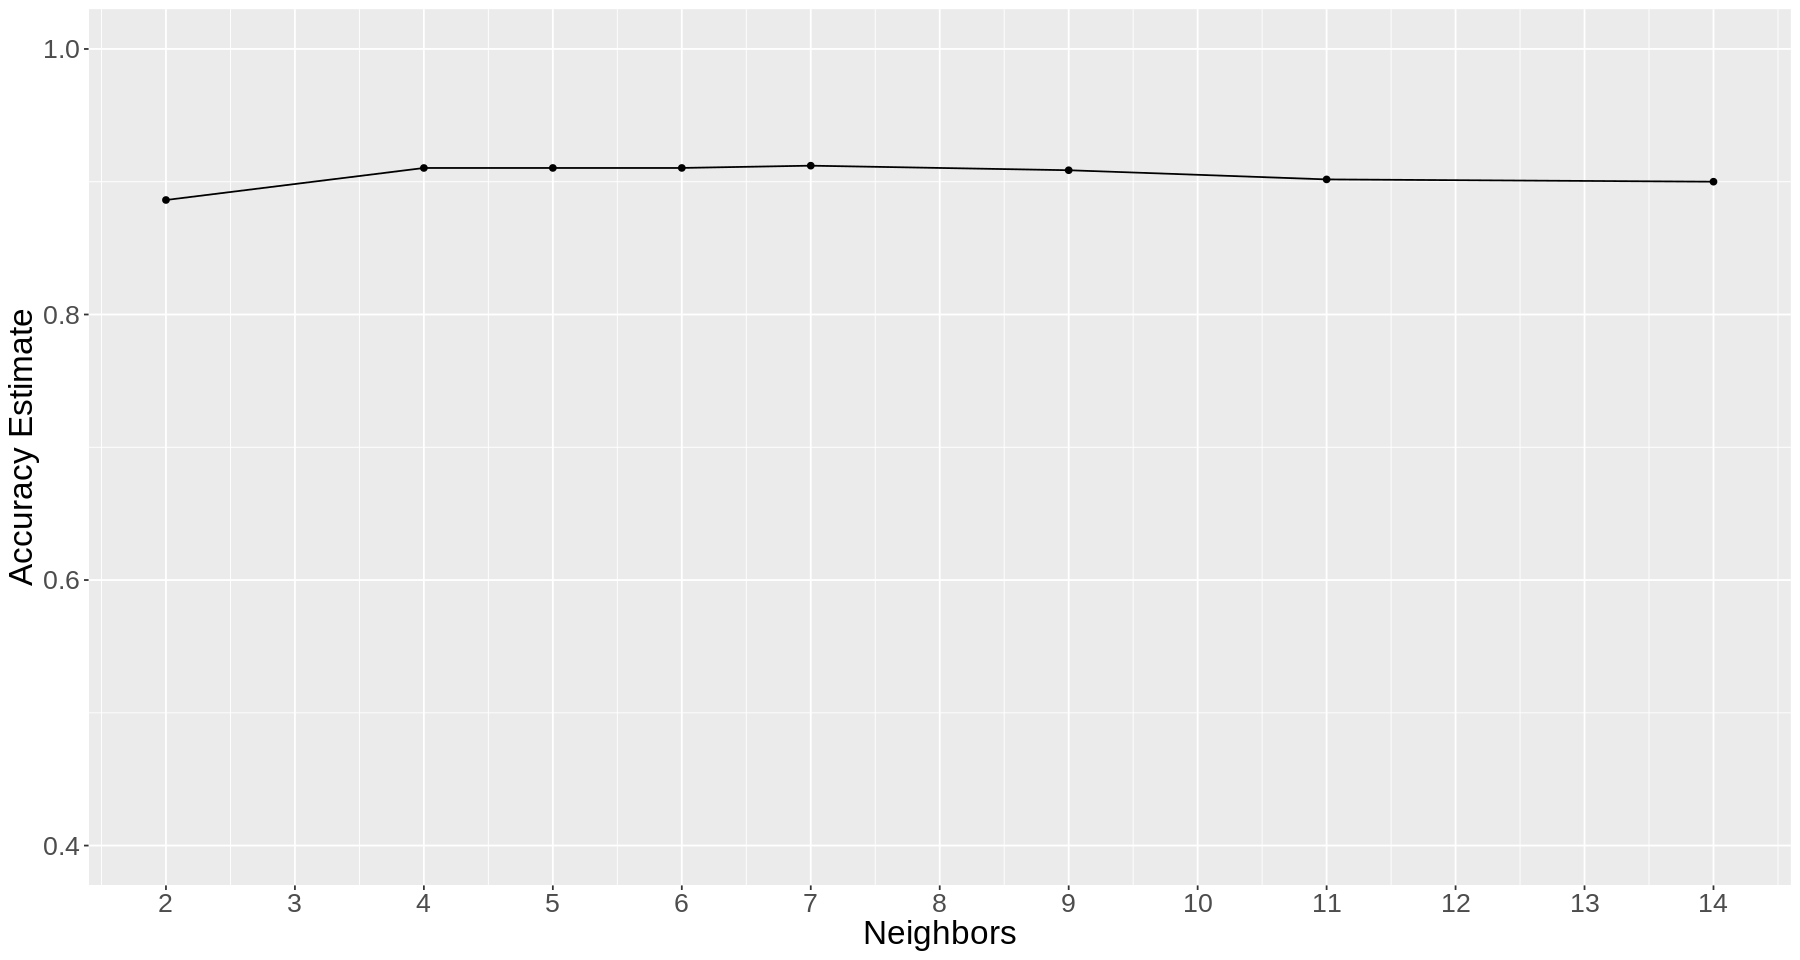

In [9]:
set.seed(1000)
trial_recipe <- recipe(Risk ~ ., data = trial_train)

knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

trial_vfold <- vfold_cv(trial_train, v=5, strata=Risk)

trial_workflow <- workflow() |>
                  add_recipe(trial_recipe) |>
                  add_model(knn_spec) |>
                  tune_grid(resamples=trial_vfold, grid=10) |>
                  collect_metrics()

accuracies <- trial_workflow |> 
      filter(.metric=='accuracy')

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +
      scale_y_continuous(limits = c(0.4, 1.0)) + theme(text = element_text(size = 20))

cross_val_plot

In [10]:
k_final <- 5

knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=k_final) |>
            set_engine("kknn") |>
            set_mode("classification")

trial_fit <- workflow() |>
              add_recipe(trial_recipe) |>
              add_model(knn_spec) |>
              fit(data = trial_train)

trial_predictions <- predict(trial_fit , trial_test) |>
      bind_cols(trial_test)

# trial_predictions


In [11]:
trial_prediction_accuracy <- trial_predictions |>
                            metrics(truth = Risk, estimate = .pred_class)    
trial_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8923077
kap,binary,0.7780367


In [12]:
trial_prediction_conf_mat <- trial_predictions |>
                             conf_mat(truth = Risk, estimate = .pred_class)

trial_prediction_conf_mat

          Truth
Prediction   0   1
         0  69  17
         1   4 105